In [ ]:
import pandas as pd  # Data manipulation using DataFrames
import numpy as np  # Numerical operations
from sklearn.model_selection import train_test_split  # Splitting data into train and test sets
from sklearn.preprocessing import StandardScaler  # Standardizing numerical features
# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
# Machine Learning Models
from sklearn.linear_model import LogisticRegression  # Logistic Regression
from sklearn.tree import DecisionTreeClassifier  # Decision Tree
from sklearn.ensemble import RandomForestClassifier  # Random Forest
from sklearn.svm import SVC  # Support Vector Machine
from sklearn.neighbors import KNeighborsClassifier  # K-Nearest Neighbors
import xgboost as xgb  # Gradient Boosting
from sklearn.model_selection import cross_val_score, KFold  # Cross-Validation
# Model Evaluation Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Evaluation metrics
from sklearn.model_selection import GridSearchCV  # Grid search for hyperparameter tuning
from sklearn.metrics import roc_curve, auc  # Receiver Operating Characteristic (ROC) curve
# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE # Handling Imbalanced Classes

In [ ]:
# Reading the cleaned credit data from a CSV file saved in the notebook 1
Credit_data_cleaned = pd.read_csv('Credit_data_cleaned_ML.csv')

In [ ]:
Credit_data_cleaned.columns

Index(['Ind_ID', 'Gender', 'Car_Owner', 'Propert_Owner', 'Annual_income',
       'Type_Income', 'Education', 'Marital_status', 'Housing_type', 'Label',
       'Age', 'Employed_Years', 'Age_Category'],
      dtype='object')

# 1.  Scaling the Data


In [ ]:
# Defining features for model training
features = ['Employed_Years', 'Annual_income', 'Age', 'Type_Income', 'Education', 'Marital_status']
X = Credit_data_cleaned[features]
y = Credit_data_cleaned['Label']

# Performing a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Model Training

## 1. Logistic Regression

### 1.1 Model training

In [ ]:
# Creating and fitting the Logistic Regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

### 1.2 Model Prediction and Accuracy

In [ ]:
# Making predictions on the training set
y_train_pred_lr = lr_model.predict(X_train_scaled)

# Calculating training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred_lr)
print(f"Calculating training accuracy: {train_accuracy:.2f}")

# Making predictions on the test set
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Calculating testing accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_lr)
print(f"Calculating testing accuracy: {test_accuracy:.2f}")

Calculating training accuracy: 0.91
Calculating testing accuracy: 0.87


### 1.2.1 SHAP and LIME Implementation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


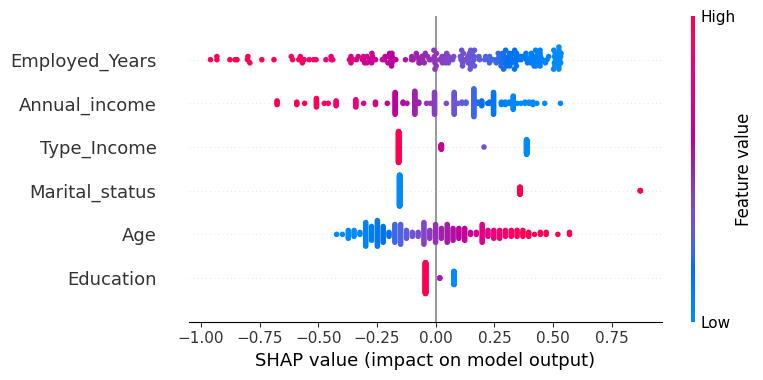

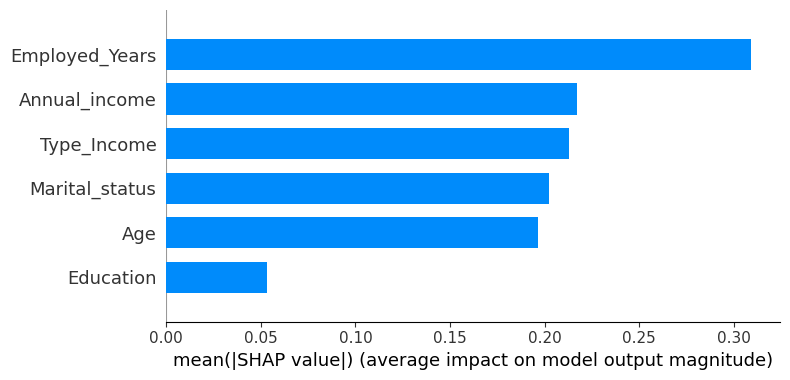


🔹 Top LIME Explanations:
Marital_status <= -0.52                  -> -0.041
-0.21 < Employed_Years <= 0.63           -> -0.012
-1.54 < Education <= 0.66                -> -0.011
Type_Income <= -1.56                     -> +0.008
-0.72 < Annual_income <= -0.04           -> +0.008
-0.06 < Age <= 0.78                      -> +0.007


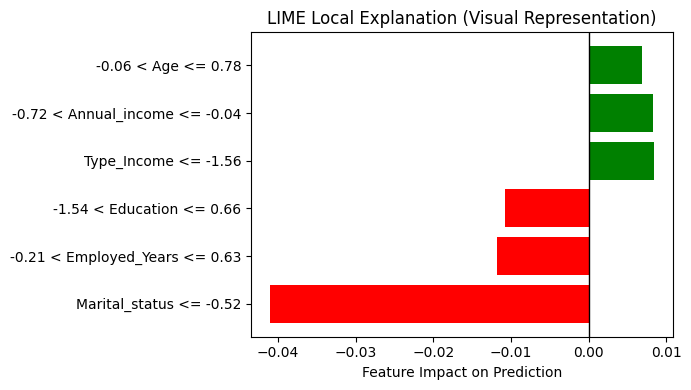


✅ Visual and HTML LIME explanations generated successfully.


In [ ]:
!pip install lime shap --quiet

import shap
import matplotlib.pyplot as plt
from lime import lime_tabular
import numpy as np
import pandas as pd

# ---- SHAP ----
explainer_shap = shap.LinearExplainer(lr_model, X_train_scaled, feature_perturbation="interventional")
shap_values = explainer_shap.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, plot_type="bar")

# ---- LIME ----
X_train_np = np.array(X_train_scaled)
X_test_np = np.array(X_test_scaled)

explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=X.columns.tolist(),
    class_names=['Class 0', 'Class 1'],
    discretize_continuous=True,
    mode='classification'
)

sample_index = 1
x_scaled = X_test_np[sample_index]
lime_exp = explainer_lime.explain_instance(
    data_row=x_scaled,
    predict_fn=lr_model.predict_proba,
    num_features=min(10, X.shape[1])
)

# textual summary
print("\n🔹 Top LIME Explanations:")
for feat, weight in lime_exp.as_list():
    print(f"{feat:40s} -> {weight:+.3f}")

# ---- Visual Representation ----
lime_results = pd.DataFrame(lime_exp.as_list(), columns=['Feature', 'Contribution'])
lime_results['Sign'] = lime_results['Contribution'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

plt.figure(figsize=(7, 4))
plt.barh(lime_results['Feature'], lime_results['Contribution'], color=lime_results['Sign'].map({'Positive': 'green', 'Negative': 'red'}))
plt.axvline(0, color='black', linewidth=1)
plt.xlabel("Feature Impact on Prediction")
plt.title("LIME Local Explanation (Visual Representation)")
plt.tight_layout()
plt.show()

lime_exp.save_to_file("lime_explanation_clean.html")
print("\n✅ Visual and HTML LIME explanations generated successfully.")


### 1.3 Confusion Matrix

<Figure size 800x600 with 0 Axes>

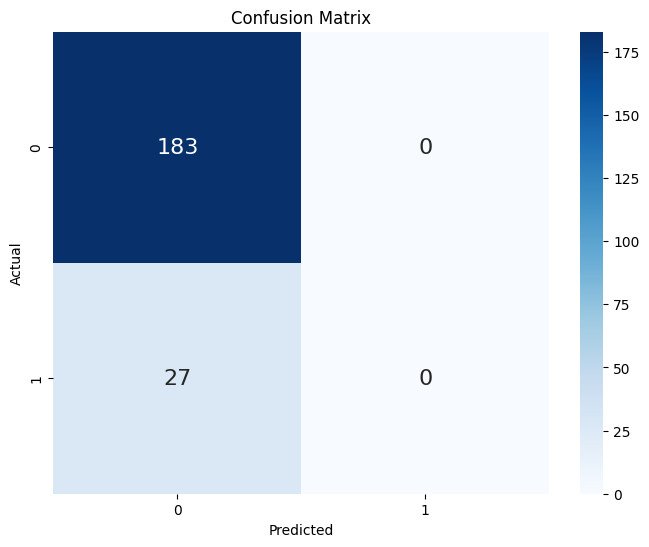

In [ ]:
# Calculating the confusion matrix
conf_matrix_lr = confusion_matrix(y_test, y_test_pred_lr)
plt.figure(figsize=(8, 6))

# Visualizing the confusion matrix with heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})

# Adding title and labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Displaying the heatmap
plt.show()

### 1.4 Classification Report

In [ ]:
# Evaluating the performance of the model
class_report_lr = classification_report(y_test, y_test_pred_lr)
print(class_report_lr)

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       183
           1       0.00      0.00      0.00        27

    accuracy                           0.87       210
   macro avg       0.44      0.50      0.47       210
weighted avg       0.76      0.87      0.81       210



### 1.5 Roc Cruve (Receiver Operating Characteristic)

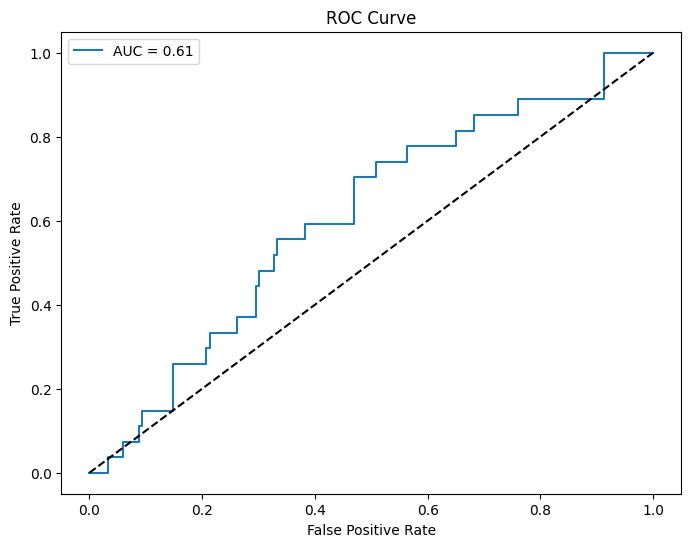

In [ ]:
# Calculating the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test_scaled)[:, 1])

# Calculating AUC (Area Under the ROC Curve)
roc_auc_lr = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_lr:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### 1.6 Cross Validation

In [ ]:
# Creating a cross-validation object
random_seed = 42
kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)

# Performing cross-validation for Logistic Regression model
cross_val_accuracy_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=kf, scoring='accuracy')
print(f"Cross-Validation Accuracy (LR): {cross_val_accuracy_lr}")

# Calculating the mean cross-validation accuracy for Logistic Regression
print(f"Mean Cross-Validation Accuracy (LR): {np.mean(cross_val_accuracy_lr):.2f}")

Cross-Validation Accuracy (LR): [0.91071429 0.9047619  0.89221557 0.92215569 0.91616766]
Mean Cross-Validation Accuracy (LR): 0.91


### 1.7  Hyperparameter Tuning: GridSearchCV

In [ ]:
# Setting up the parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Adjusting the regularization parameter
    'max_iter': [100, 200, 300],  # Setting the maximum number of iterations
}

# Setting up GridSearchCV for logistic regression
grid_search_lr = GridSearchCV(lr_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fitting the model with the training data
grid_search_lr.fit(X_train_scaled, y_train)

# Retrieving the best parameters from the grid search
best_params_lr = grid_search_lr.best_params_
print("Best Parameters (Logistic Regression):", best_params_lr)

Best Parameters (Logistic Regression): {'C': 0.001, 'max_iter': 100}


### 1.8 Model with Best Parameters

In [ ]:
# Defining the best hyperparameters for Logistic Regression
best_params_lr = {'C': 0.001, 'max_iter': 100}

# Creating the Logistic Regression model with the best hyperparameters
best_lr_model = LogisticRegression(**best_params_lr, random_state=42)
best_lr_model.fit(X_train_scaled, y_train)
y_pred_lr = best_lr_model.predict(X_test_scaled)

# Calculating the accuracy of the Logistic Regression model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy (LR): {accuracy_lr:.2f}")

Accuracy (LR): 0.87


### 1.8.1 SHAP and LIME Implementation

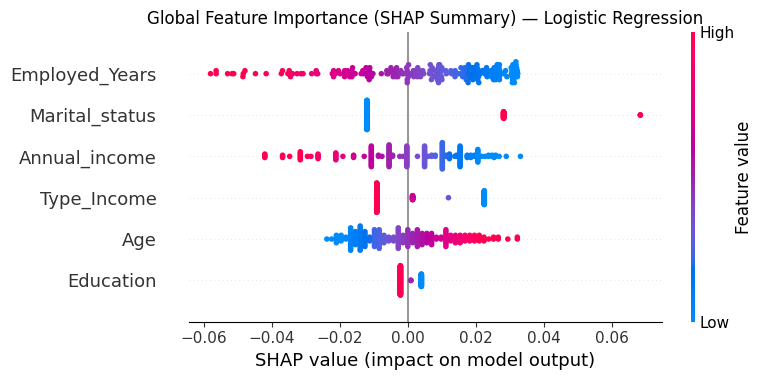

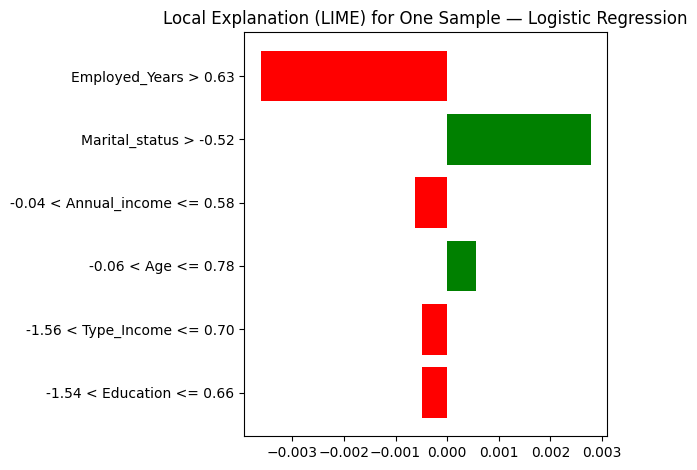

Explained instance index: 144


In [ ]:
import shap
import lime
from lime import lime_tabular
import matplotlib.pyplot as plt
import numpy as np

# SHAP Analysis
explainer_shap = shap.Explainer(best_lr_model, X_train_scaled)
shap_values = explainer_shap(X_test_scaled)

plt.title("Global Feature Importance (SHAP Summary) — Logistic Regression")
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)

# LIME Analysis
explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=X_train.columns,
    class_names=np.unique(y_train).astype(str),
    mode='classification'
)

i = np.random.randint(0, X_test_scaled.shape[0])
exp = explainer_lime.explain_instance(X_test_scaled[i], best_lr_model.predict_proba, num_features=10)

# LIME Visual Representation
fig = exp.as_pyplot_figure()
plt.title("Local Explanation (LIME) for One Sample — Logistic Regression")
plt.tight_layout()
plt.show()

print(f"Explained instance index: {i}")

## 2. Decision Tree Classifier

- In decision tree models, normalization is not necessary. Decision trees are not sensitive to the scale of the features.

### 2.1 Model training

In [ ]:
# Creating and fitting the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### 2.2 Model Prediction and Accuracy

In [ ]:
# Making predictions on the training set
y_pred_dt = dt_model.predict(X_test)

# Calculating testing accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy: {accuracy_dt:.2f}")

Accuracy: 0.84


### 2.2.1 SHAP and LIME Implementation

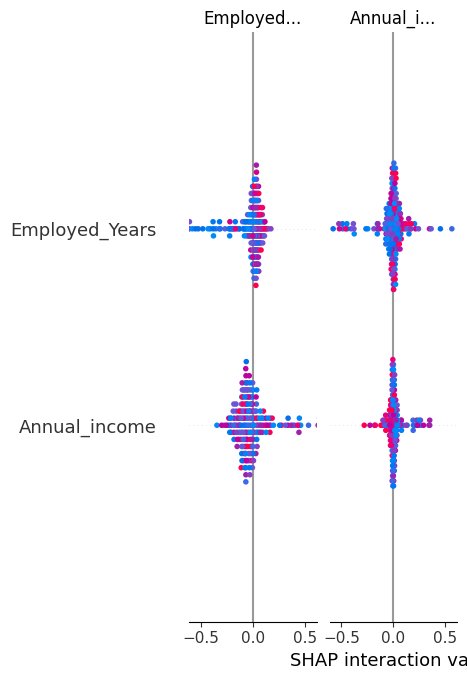

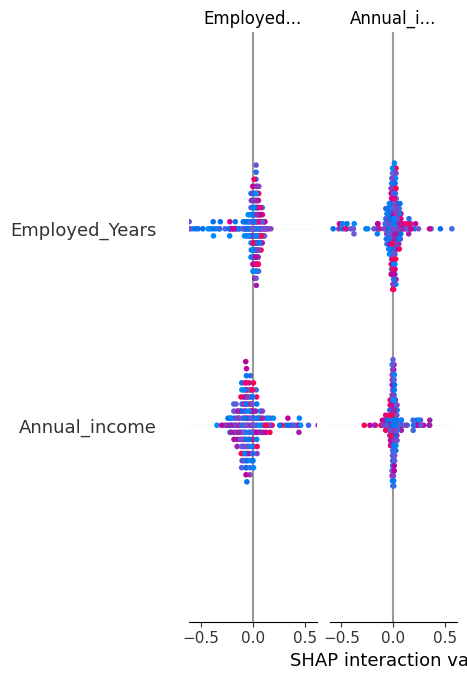


🔹 Top LIME Explanations:
Marital_status <= 0.00                   -> -0.083
2.52 < Employed_Years <= 4.86            -> +0.062
1.00 < Education <= 3.00                 -> -0.053
Age <= 32.00                             -> -0.044
180000.00 < Annual_income <= 225000.00   -> +0.019
0.00 < Type_Income <= 3.00               -> -0.007


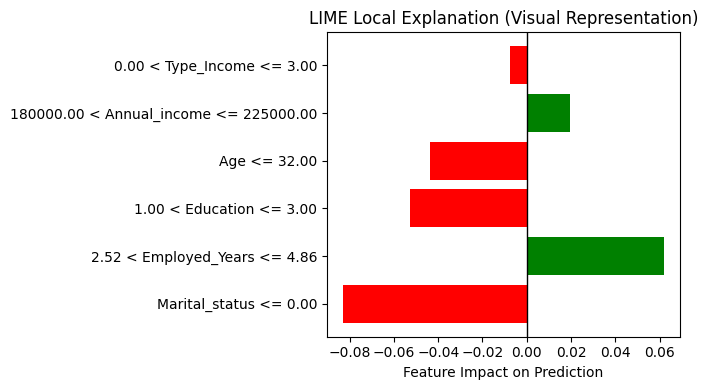

In [ ]:
!pip install shap lime --quiet

import shap
import matplotlib.pyplot as plt
from lime import lime_tabular
import numpy as np
import pandas as pd

# ===== SHAP (Global + Local) =====
explainer_shap = shap.TreeExplainer(dt_model)
shap_values = explainer_shap.shap_values(X_test)

# Global importance (SHAP summary)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")

# ===== LIME (Local Explanation) =====
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)

explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=X.columns.tolist(),
    class_names=[str(c) for c in np.unique(y_test)],
    discretize_continuous=True,
    mode='classification'
)

sample_index = 0
x_sample = X_test_np[sample_index]
lime_exp = explainer_lime.explain_instance(
    data_row=x_sample,
    predict_fn=dt_model.predict_proba,
    num_features=min(10, X.shape[1])
)

# Text summary
print("\n🔹 Top LIME Explanations:")
for feat, weight in lime_exp.as_list():
    print(f"{feat:40s} -> {weight:+.3f}")

# ===== LIME Visual Representation =====
lime_results = pd.DataFrame(lime_exp.as_list(), columns=['Feature', 'Contribution'])
lime_results['Sign'] = lime_results['Contribution'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

plt.figure(figsize=(7, 4))
plt.barh(lime_results['Feature'], lime_results['Contribution'],
         color=lime_results['Sign'].map({'Positive': 'green', 'Negative': 'red'}))
plt.axvline(0, color='black', linewidth=1)
plt.xlabel("Feature Impact on Prediction")
plt.title("LIME Local Explanation (Visual Representation)")
plt.tight_layout()
plt.show()

lime_exp.save_to_file("lime_explanation_tree.html")

### 2.3 Confusion Matrix

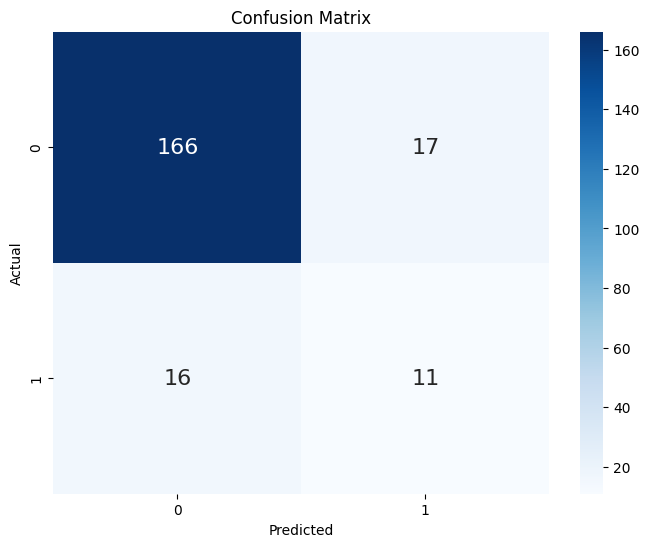

In [ ]:
# Calculating the confusion matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(8, 6))

# Visualizing the confusion matrix with heatmap
sns.heatmap(conf_matrix_dt, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})

# Adding title and labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Displaying the heatmap
plt.show()

### 2.4 Classification Report

In [ ]:
# Evaluating the performance of the model
class_report_dt = classification_report(y_test, y_pred_dt)
print(class_report_dt)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       183
           1       0.39      0.41      0.40        27

    accuracy                           0.84       210
   macro avg       0.65      0.66      0.65       210
weighted avg       0.85      0.84      0.84       210



### 2.5 Roc Cruve (Receiver Operating Characteristic)

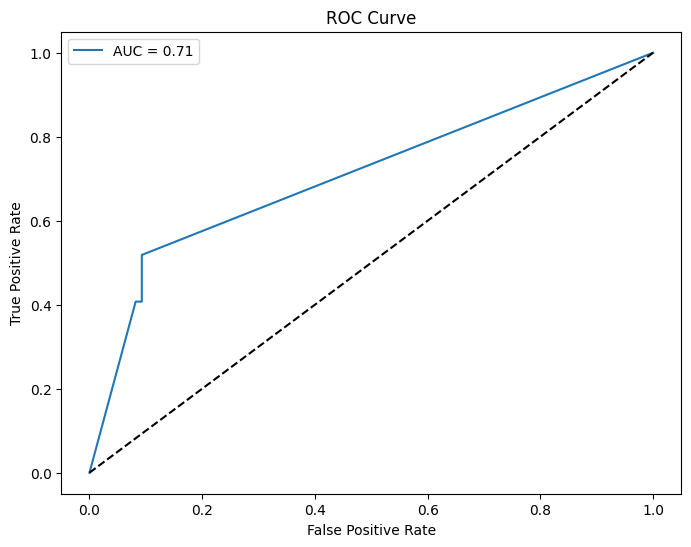

In [ ]:
# Calculating the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, dt_model.predict_proba(X_test)[:, 1])

# Calculating AUC (Area Under the ROC Curve)
roc_auc_dt = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_dt:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### 2.6 Cross Validation

In [ ]:
# Creating a cross-validation object
random_seed = 42
kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)

# Performing cross-validation for Decision Tree model
cross_val_accuracy_dt = cross_val_score(dt_model, X_train, y_train, cv=kf, scoring='accuracy')
print(f"Cross-Validation Accuracy (DT): {cross_val_accuracy_dt}")

# Calculating the mean cross-validation accuracy for Decision Tree model
print(f"Mean Cross-Validation Accuracy (DT): {np.mean(cross_val_accuracy_dt):.2f}")

Cross-Validation Accuracy (DT): [0.86904762 0.88095238 0.8502994  0.8742515  0.92814371]
Mean Cross-Validation Accuracy (DT): 0.88


### 2.7  Hyperparameter Tuning: GridSearchCV

In [ ]:
# Setting up the parameter grid for grid search
param_grid_dt = {
    'max_depth': [None, 5, 10, 15],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Setting up GridSearchCV for Decision Tree model
grid_search_dt = GridSearchCV(dt_model, param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1)

# Fitting the model with the training data
grid_search_dt.fit(X_train, y_train)

# Retrieving the best parameters from the grid search
best_params_dt = grid_search_dt.best_params_
print("Best Parameters (Decision Tree):", best_params_dt)


Best Parameters (Decision Tree): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


### 2.8 Model with Best Parameters

In [ ]:
# Defining the best hyperparameters for Decision Tree model
best_params_dt = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}

# Creating the Decision Tree model with the best hyperparameters
best_dt_model = DecisionTreeClassifier(**best_params_dt, random_state=42)
best_dt_model.fit(X_train_scaled, y_train)
y_pred_dt = best_dt_model.predict(X_test_scaled)

# Calculating the accuracy of the Decision Tree model
accuracy_dt_bp = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy (DT): {accuracy_dt_bp:.2f}")

Accuracy (DT): 0.85


### 2.8.1 SHAP and LIME Implementation

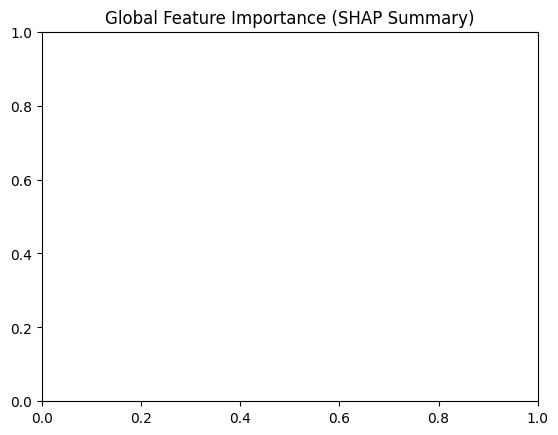

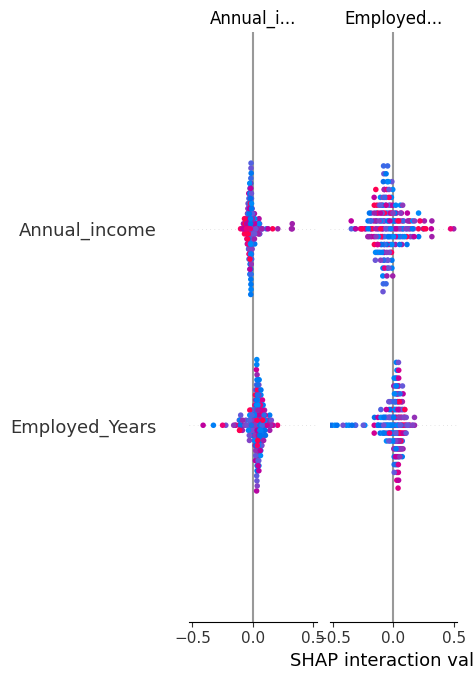

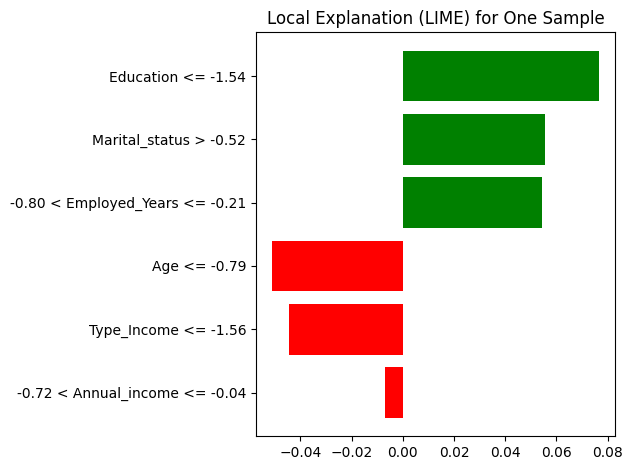

Explained instance index: 57


In [ ]:
import shap
import lime
from lime import lime_tabular
import matplotlib.pyplot as plt
import numpy as np

# SHAP Analysis
explainer_shap = shap.Explainer(best_dt_model, X_train_scaled)
shap_values = explainer_shap(X_test_scaled)

plt.title("Global Feature Importance (SHAP Summary)")
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)

# LIME Analysis
explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=X_train.columns,
    class_names=np.unique(y_train).astype(str),
    mode='classification'
)

i = np.random.randint(0, X_test_scaled.shape[0])
exp = explainer_lime.explain_instance(X_test_scaled[i], best_dt_model.predict_proba, num_features=10)

# LIME Visual Representation
fig = exp.as_pyplot_figure()
plt.title("Local Explanation (LIME) for One Sample")
plt.tight_layout()
plt.show()

print(f"Explained instance index: {i}")


## 3. Random Forest Classifier

### 3.1 Model training

In [ ]:
# Creating and fitting the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

### 3.2 Model Prediction and Accuracy

In [ ]:
# Making predictions on the training set
y_train_pred_rf = rf_model.predict(X_train_scaled)

# Calculating training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred_rf)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Making predictions on the test set
y_test_pred_rf = rf_model.predict(X_test_scaled)

# Calculating testing accuracy
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print(f"Testing Accuracy: {test_accuracy_rf:.2f}")

Training Accuracy: 0.99
Testing Accuracy: 0.91


### 3.2.1 SHAP and LIME Implementation

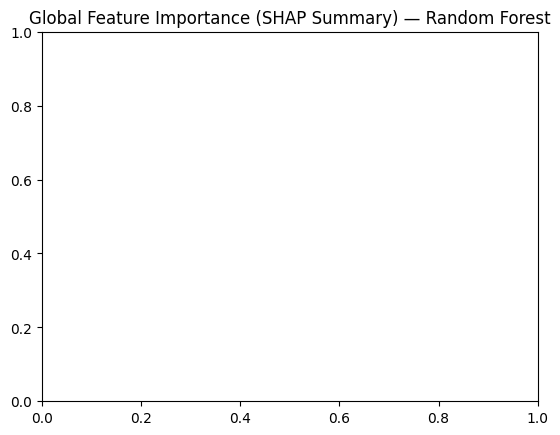

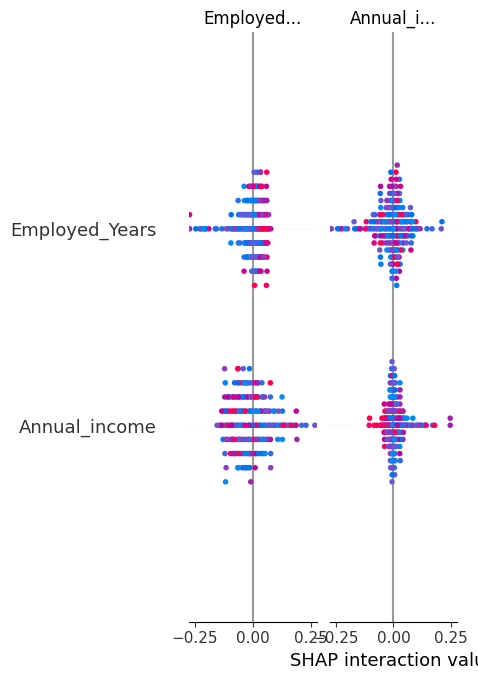

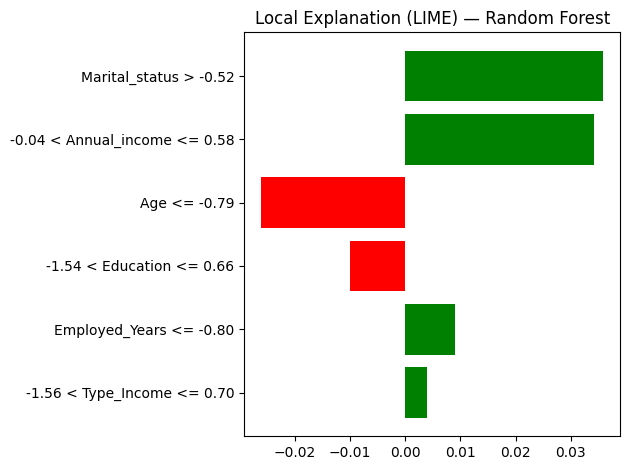

Explained instance index: 193


In [ ]:
import shap
import lime
from lime import lime_tabular
import matplotlib.pyplot as plt
import numpy as np

# --- SHAP (Tree Optimized) ---
explainer_shap = shap.TreeExplainer(
    rf_model,
    feature_perturbation="tree_path_dependent"
)
shap_values = explainer_shap.shap_values(X_test_scaled, check_additivity=False)

# Auto-detect the correct SHAP value format
if isinstance(shap_values, list):
    shap_to_plot = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    shap_to_plot = shap_values

# Global Feature Importance
plt.title("Global Feature Importance (SHAP Summary) — Random Forest")
shap.summary_plot(shap_to_plot, X_test_scaled, feature_names=X_test.columns)

# --- LIME (Local Explainability) ---
explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=X_train.columns,
    class_names=np.unique(y_train).astype(str),
    mode='classification'
)

i = np.random.randint(0, X_test_scaled.shape[0])
exp = explainer_lime.explain_instance(X_test_scaled[i], rf_model.predict_proba, num_features=10)

fig = exp.as_pyplot_figure()
plt.title("Local Explanation (LIME) — Random Forest")
plt.tight_layout()
plt.show()

print(f"Explained instance index: {i}")

### 3.3 Confusion Matrix

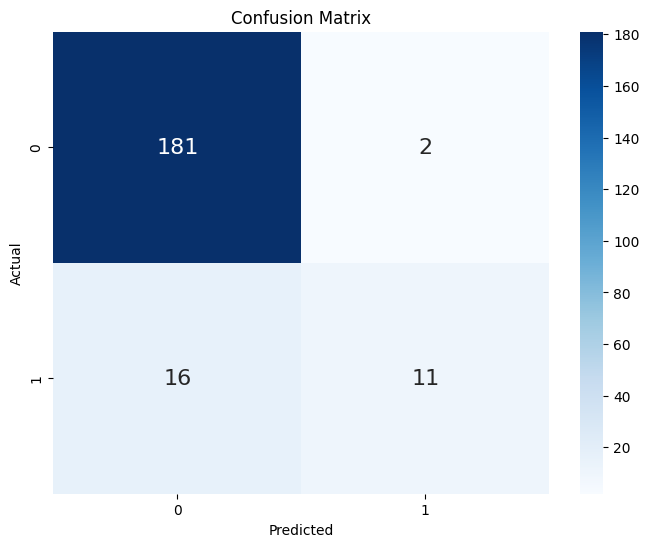

In [ ]:
# Calculating the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)
plt.figure(figsize=(8, 6))

# Visualizing the confusion matrix with heatmap
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})

# Adding title and labels
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Displaying the heatmap
plt.show()

### 3.4 Classification Report

In [ ]:
# Evaluating the performance of the model
class_report_rf = classification_report(y_test, y_test_pred_rf)
print(class_report_rf)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       183
           1       0.85      0.41      0.55        27

    accuracy                           0.91       210
   macro avg       0.88      0.70      0.75       210
weighted avg       0.91      0.91      0.90       210



### 3.5 Roc Cruve (Receiver Operating Characteristic)

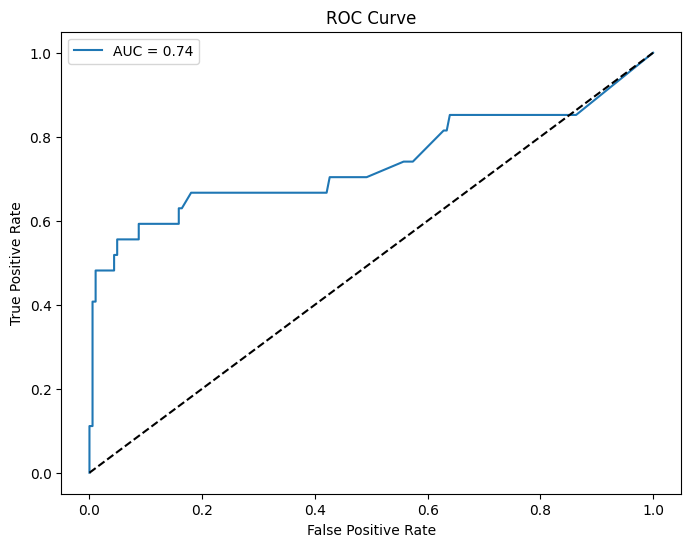

In [ ]:
# Calculating the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])

# Calculating AUC (Area Under the ROC Curve)
roc_auc_rf = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_rf:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### 3.6 Cross Validation

In [ ]:
# Creating a cross-validation object
random_seed = 42
kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)

# Performing cross-validation for Random Forest model
cross_val_accuracy_rf = cross_val_score(rf_model, X_train_scaled, y_train, cv=kf, scoring='accuracy')
print(f"Cross-Validation Accuracy (RF): {cross_val_accuracy_rf}")

# Calculating the mean cross-validation accuracy for Random Forest model
print(f"Mean Cross-Validation Accuracy (RF): {np.mean(cross_val_accuracy_rf):.2f}")

Cross-Validation Accuracy (RF): [0.91666667 0.95238095 0.89820359 0.94011976 0.95209581]
Mean Cross-Validation Accuracy (RF): 0.93


### 3.7  Hyperparameter Tuning: GridSearchCV

In [ ]:
# Setting up the parameter grid for grid search
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 15],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}
# Setting up GridSearchCV for Random Forest model
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)

# Fitting the model with the training data
grid_search_rf.fit(X_train_scaled, y_train)

# Retrieving the best parameters from the grid search
best_params_rf = grid_search_rf.best_params_
print("Best Parameters (Random Forest):", best_params_rf)

### 3.8 Model with Best Parameters

In [ ]:
# Defining the best hyperparameters for Random Forest model
best_params_rf = {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

# Creating the Random Forest model with the best hyperparameters
best_rf_model = RandomForestClassifier(**best_params_rf, random_state=42)
best_rf_model.fit(X_train_scaled, y_train)
y_pred_rf = best_rf_model.predict(X_test_scaled)

# Calculating the accuracy of the Random Forest model
accuracy_rf_bp = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy (RFC): {accuracy_rf_bp:.2f}")

### 3.8.1 SHAP and LIME Implementation

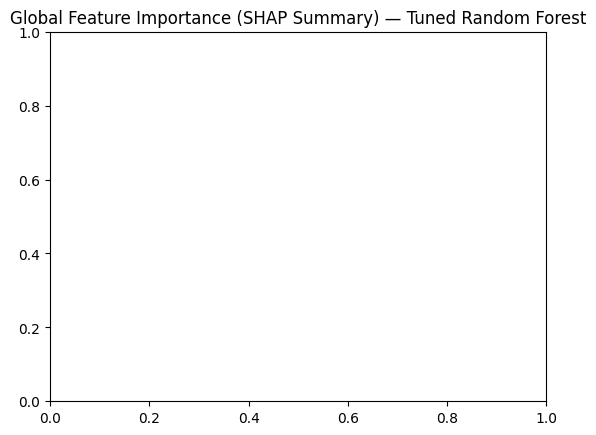

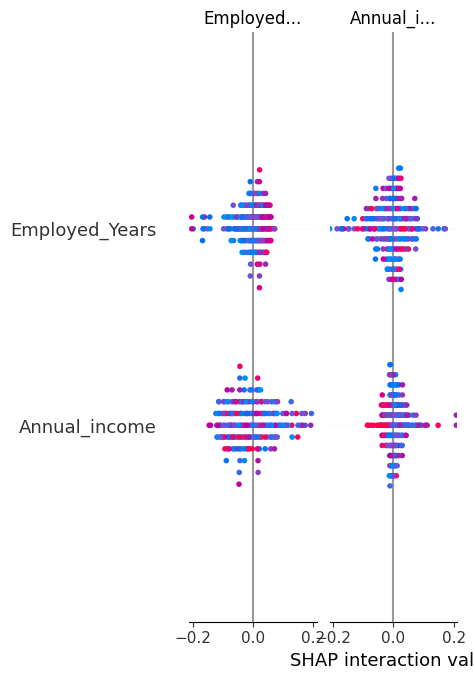

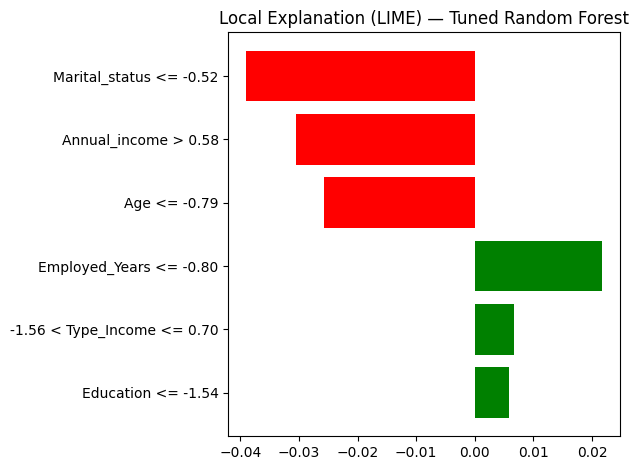

Explained instance index: 50


In [ ]:
import shap
import lime
from lime import lime_tabular
import matplotlib.pyplot as plt
import numpy as np

# --- SHAP (Tree Optimized + Auto Detection) ---
explainer_shap = shap.TreeExplainer(
    best_rf_model,
    feature_perturbation="tree_path_dependent"
)
shap_values = explainer_shap.shap_values(X_test_scaled, check_additivity=False)

# Auto-detect SHAP output format (binary / multiclass / single output)
if isinstance(shap_values, list):
    shap_to_plot = shap_values[1] if len(shap_values) > 1 else shap_values[0]
else:
    shap_to_plot = shap_values

# Global Feature Importance (SHAP Summary)
plt.title("Global Feature Importance (SHAP Summary) — Tuned Random Forest")
shap.summary_plot(shap_to_plot, X_test_scaled, feature_names=X_test.columns)

# --- LIME (Local Explainability) ---
explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=X_train.columns,
    class_names=np.unique(y_train).astype(str),
    mode='classification'
)

# Random instance for local explanation
i = np.random.randint(0, X_test_scaled.shape[0])
exp = explainer_lime.explain_instance(X_test_scaled[i], best_rf_model.predict_proba, num_features=10)

# Local Visualization (LIME)
fig = exp.as_pyplot_figure()
plt.title("Local Explanation (LIME) — Tuned Random Forest")
plt.tight_layout()
plt.show()

print(f"Explained instance index: {i}")

### 3.8.2 Downloading the model and required files

In [ ]:
import joblib

joblib.dump(best_rf_model, "best_rf_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib

df = pd.read_csv("Credit_data_cleaned_ML.csv")

# Optional: Check columns
print("Columns in dataset:")
print(df.columns.tolist())

le_income = LabelEncoder()
le_education = LabelEncoder()
le_marital = LabelEncoder()

le_income.fit(df["Type_Income"])
le_education.fit(df["Education"])
le_marital.fit(df["Marital_status"])


joblib.dump(le_income, "le_income.pkl")
joblib.dump(le_education, "le_education.pkl")
joblib.dump(le_marital, "le_marital.pkl")

print("\n✅ Encoders trained and saved successfully!")
print("Type_Income classes:", le_income.classes_)
print("Education classes:", le_education.classes_)
print("Marital_status classes:", le_marital.classes_)


Columns in dataset:
['Ind_ID', 'Gender', 'Car_Owner', 'Propert_Owner', 'Annual_income', 'Type_Income', 'Education', 'Marital_status', 'Housing_type', 'Label', 'Age', 'Employed_Years', 'Age_Category']

✅ Encoders trained and saved successfully!
Type_Income classes: [0 1 2 3]
Education classes: [0 1 2 3]
Marital_status classes: [0 1 2]


In [ ]:
import joblib

le_income = joblib.load("le_income.pkl")
le_education = joblib.load("le_education.pkl")
le_marital = joblib.load("le_marital.pkl")

print("✅ Encoders trained and loaded successfully!\n")

print("Type_Income mapping:")
for i, label in enumerate(le_income.classes_):
    print(f"{i} → {label}")

print("\nEducation mapping:")
for i, label in enumerate(le_education.classes_):
    print(f"{i} → {label}")

print("\nMarital_status mapping:")
for i, label in enumerate(le_marital.classes_):
    print(f"{i} → {label}")

✅ Encoders trained and loaded successfully!

Type_Income mapping:
0 → 0
1 → 1
2 → 2
3 → 3

Education mapping:
0 → 0
1 → 1
2 → 2
3 → 3

Marital_status mapping:
0 → 0
1 → 1
2 → 2


## 4. Support Vector Machines (SVM)

### 4.1 Model training

In [ ]:
# Creating and fitting the Support Vector Machine (SVM) model
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

SVC(probability=True, random_state=42)

### 4.2 Model Prediction and Accuracy

In [ ]:
# Making predictions on the training set
y_train_pred_svm = svm_model.predict(X_train_scaled)

# Calculating training accuracy
train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
print(f"Training Accuracy (SVM): {train_accuracy_svm:.2f}")

# Making predictions on the test set
y_test_pred_svm = svm_model.predict(X_test_scaled)

# Calculating testing accuracy
test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
print(f"Testing Accuracy (SVM): {test_accuracy_svm:.2f}")

Training Accuracy (SVM): 0.92
Testing Accuracy (SVM): 0.87


### 4.2.1 SHAP and LIME Implementation

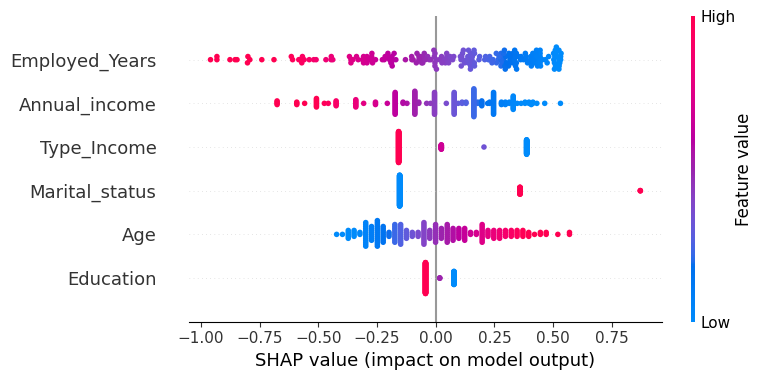

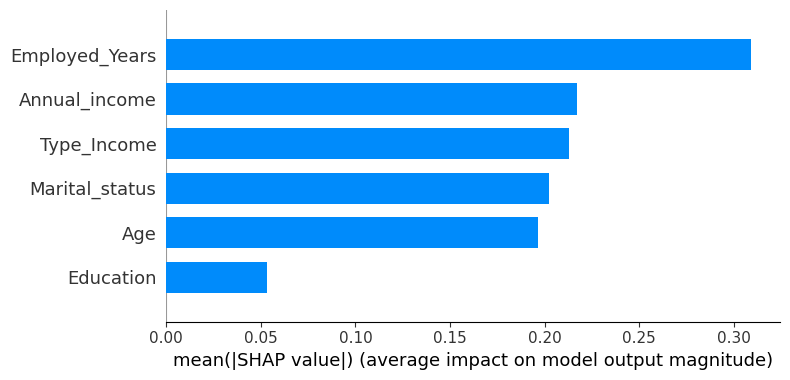


🔹 Top LIME Explanations:
Marital_status <= -0.52                  -> -0.041
-0.21 < Employed_Years <= 0.63           -> -0.012
-1.54 < Education <= 0.66                -> -0.012
Type_Income <= -1.56                     -> +0.011
-0.06 < Age <= 0.78                      -> +0.008
-0.72 < Annual_income <= -0.04           -> +0.007


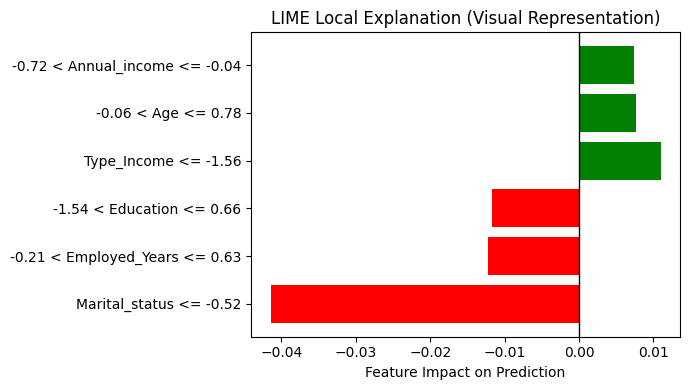

In [ ]:
!pip install lime shap --quiet

import shap
import matplotlib.pyplot as plt
from lime import lime_tabular
import numpy as np
import pandas as pd

# ---- SHAP ----
explainer_shap = shap.LinearExplainer(lr_model, X_train_scaled, feature_perturbation="interventional")
shap_values = explainer_shap.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, plot_type="bar")

# ---- LIME ----
X_train_np = np.array(X_train_scaled)
X_test_np = np.array(X_test_scaled)

explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=X.columns.tolist(),
    class_names=['Class 0', 'Class 1'],
    discretize_continuous=True,
    mode='classification'
)

sample_index = 1
x_scaled = X_test_np[sample_index]
lime_exp = explainer_lime.explain_instance(
    data_row=x_scaled,
    predict_fn=lr_model.predict_proba,
    num_features=min(10, X.shape[1])
)

# textual summary
print("\n🔹 Top LIME Explanations:")
for feat, weight in lime_exp.as_list():
    print(f"{feat:40s} -> {weight:+.3f}")

# ---- Visual Representation ----
lime_results = pd.DataFrame(lime_exp.as_list(), columns=['Feature', 'Contribution'])
lime_results['Sign'] = lime_results['Contribution'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

plt.figure(figsize=(7, 4))
plt.barh(lime_results['Feature'], lime_results['Contribution'], color=lime_results['Sign'].map({'Positive': 'green', 'Negative': 'red'}))
plt.axvline(0, color='black', linewidth=1)
plt.xlabel("Feature Impact on Prediction")
plt.title("LIME Local Explanation (Visual Representation)")
plt.tight_layout()
plt.show()

lime_exp.save_to_file("lime_explanation_clean.html")

### 4.3 Confusion Matrix

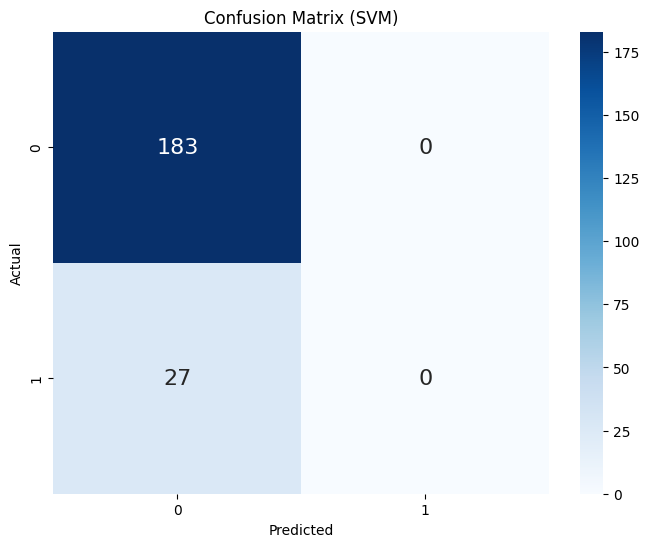

In [ ]:
# Calculating the confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_test_pred_svm)
plt.figure(figsize=(8, 6))

# Visualizing the confusion matrix with heatmap
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})

# Adding title and labels
plt.title("Confusion Matrix (SVM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Displaying the heatmap
plt.show()

### 4.4 Classification Report

In [ ]:
# Evaluating the performance of the model
class_report_svm = classification_report(y_test, y_test_pred_svm)
print("Classification Report (SVM):\n", class_report_svm)

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.87      1.00      0.93       183
           1       0.00      0.00      0.00        27

    accuracy                           0.87       210
   macro avg       0.44      0.50      0.47       210
weighted avg       0.76      0.87      0.81       210



### 4.5 Roc Cruve (Receiver Operating Characteristic)

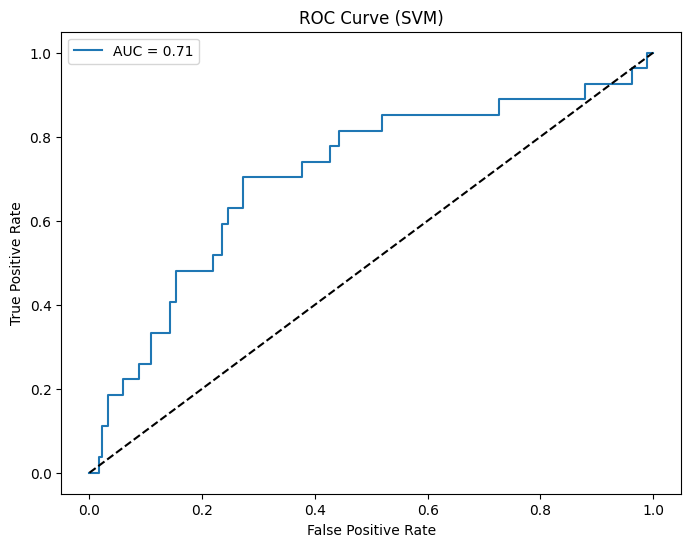

In [ ]:
# Calculating the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm_model.predict_proba(X_test_scaled)[:, 1])

# Calculating AUC (Area Under the ROC Curve)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'AUC = {roc_auc_svm:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (SVM)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### 4.6 Cross Validation

In [ ]:
# Creating a cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)

# Performing cross-validation for Support Vector Machine (SVM) model
cross_val_accuracy_svm = cross_val_score(svm_model, X_train_scaled, y_train, cv=kf, scoring='accuracy')
print(f"Cross-Validation Accuracy (SVM): {cross_val_accuracy_svm}")

# Calculating the mean cross-validation accuracy for Support Vector Machine (SVM) model
print(f"Mean Cross-Validation Accuracy (SVM): {np.mean(cross_val_accuracy_svm):.2f}")

Cross-Validation Accuracy (SVM): [0.91071429 0.9047619  0.88622754 0.92215569 0.91616766]
Mean Cross-Validation Accuracy (SVM): 0.91


### 4.7  Hyperparameter Tuning: GridSearchCV

In [ ]:
# Setting up the parameter grid for grid search
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf' and 'poly'
}

# Setting up GridSearchCV for Support Vector Machine (SVM) model
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='roc_auc', n_jobs=-1)

# Fitting the model with the training data
grid_search_svm.fit(X_train_scaled, y_train)

# Retrieving the best parameters from the grid search
best_params_svm = grid_search_svm.best_params_
print("Best Parameters (SVM):", best_params_svm)

Best Parameters (SVM): {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


### 4.8 Model with Best Parameters

In [ ]:
# Defining the best hyperparameters for Support Vector Machine (SVM) model
best_params_svm = {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

# Creating the Support Vector Machine (SVM) model with the best hyperparameters
best_svm_model = SVC(**best_params_svm, probability=True, random_state=42)
best_svm_model.fit(X_train_scaled, y_train)
y_pred_svm = best_svm_model.predict(X_test_scaled)

# Calculating the accuracy of the Support Vector Machine (SVM) model
accuracy_svm_bp = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy (SVM): {accuracy_svm_bp:.2f}")

Accuracy (SVM): 0.87


### 4.8.1 SHAP and LIME Implementation

✅ Accuracy (SVM): 0.87


  0%|          | 0/100 [00:00<?, ?it/s]

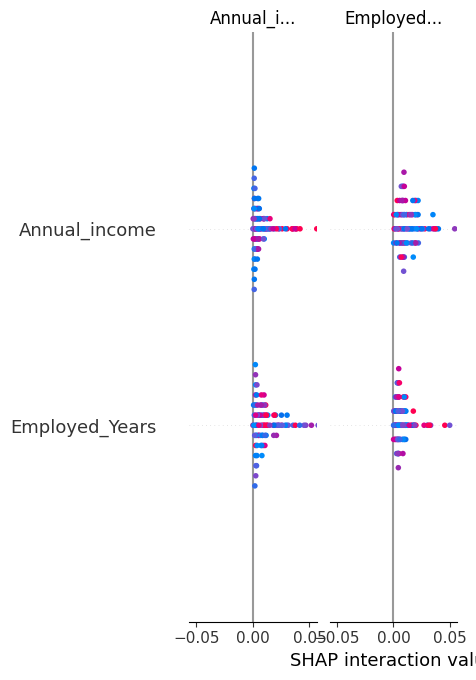


🔹 Top LIME Explanations:
Marital_status <= -0.52                  -> -0.026
-1.54 < Education <= 0.66                -> -0.022
-0.72 < Annual_income <= -0.04           -> +0.011
-0.06 < Age <= 0.78                      -> -0.007
Type_Income <= -1.56                     -> +0.005
-0.21 < Employed_Years <= 0.63           -> +0.002


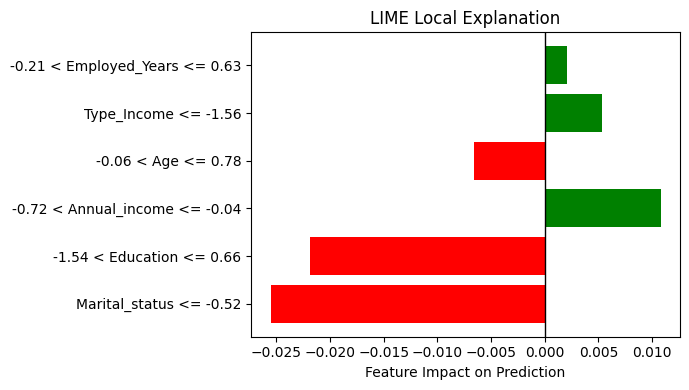

In [ ]:
!pip install shap lime --quiet

import shap
import matplotlib.pyplot as plt
from lime import lime_tabular
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

best_params_svm = {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
best_svm_model = SVC(**best_params_svm, probability=True, random_state=42)
best_svm_model.fit(X_train_scaled, y_train)

y_pred_svm = best_svm_model.predict(X_test_scaled)
accuracy_svm_bp = accuracy_score(y_test, y_pred_svm)
print(f"✅ Accuracy (SVM): {accuracy_svm_bp:.2f}")

explainer_shap = shap.KernelExplainer(
    model=best_svm_model.predict_proba,
    data=shap.sample(X_train_scaled, 100)
)
X_sample = X_test_scaled[:100]
shap_values = explainer_shap.shap_values(X_sample)

if isinstance(shap_values, list):
    shap_values_combined = np.mean(np.abs(np.stack(shap_values, axis=0)), axis=0)
else:
    shap_values_combined = np.abs(shap_values)

shap.summary_plot(shap_values_combined, X_sample, feature_names=X.columns, plot_type="bar")
plt.savefig("svm_shap_summary_bar_combined.png", bbox_inches='tight')
plt.close()

X_train_np = np.array(X_train_scaled)
X_test_np = np.array(X_test_scaled)
explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=X.columns.tolist(),
    class_names=[f"Class {i}" for i in np.unique(y_train)],
    discretize_continuous=True,
    mode='classification'
)

sample_index = 1
x_scaled = X_test_np[sample_index]
lime_exp = explainer_lime.explain_instance(
    data_row=x_scaled,
    predict_fn=best_svm_model.predict_proba,
    num_features=min(10, X.shape[1])
)

print("\n🔹 Top LIME Explanations:")
for feat, weight in lime_exp.as_list():
    print(f"{feat:40s} -> {weight:+.3f}")

lime_results = pd.DataFrame(lime_exp.as_list(), columns=['Feature', 'Contribution'])
lime_results['Sign'] = lime_results['Contribution'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

plt.figure(figsize=(7, 4))
plt.barh(lime_results['Feature'], lime_results['Contribution'],
         color=lime_results['Sign'].map({'Positive': 'green', 'Negative': 'red'}))
plt.axvline(0, color='black', linewidth=1)
plt.xlabel("Feature Impact on Prediction")
plt.title("LIME Local Explanation")
plt.tight_layout()
plt.show()

lime_exp.save_to_file("lime_explanation_svm.html")

## 5. K-Nearest Neighbors (KNN)

### 5.1 Model training

In [ ]:
# Creating and fitting the KNN model
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3)

### 5.2 Model Prediction and Accuracy

In [ ]:
# Making predictions on the training set
y_train_pred_knn = knn_model.predict(X_train_scaled)

# Calculating training accuracy
train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)
print(f"Training Accuracy (KNN): {train_accuracy_knn:.2f}")

# Making predictions on the test set
y_test_pred_knn = knn_model.predict(X_test_scaled)

# Calculating testing accuracy
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)
print(f"Testing Accuracy (KNN): {test_accuracy_knn:.2f}")

Training Accuracy (KNN): 0.94
Testing Accuracy (KNN): 0.88


### 5.2.1 SHAP and LIME Implementation

Training Accuracy (KNN): 0.94
Testing Accuracy (KNN): 0.88

🔹 Generating SHAP explanations (may take some time)...


  0%|          | 0/50 [00:00<?, ?it/s]

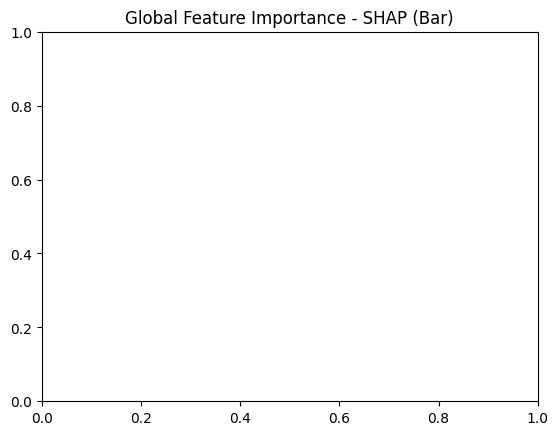

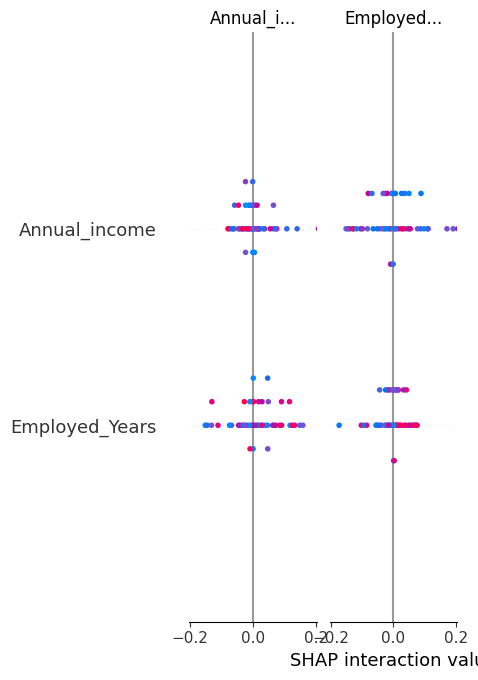

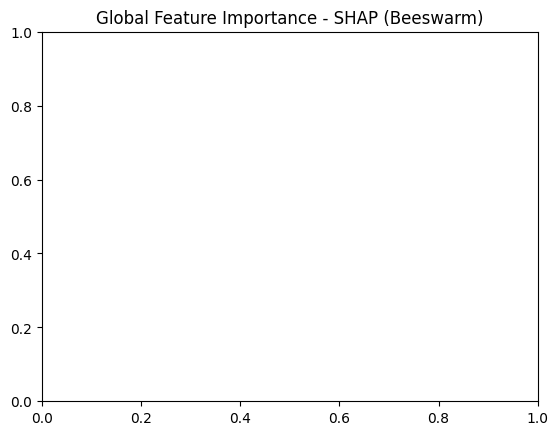

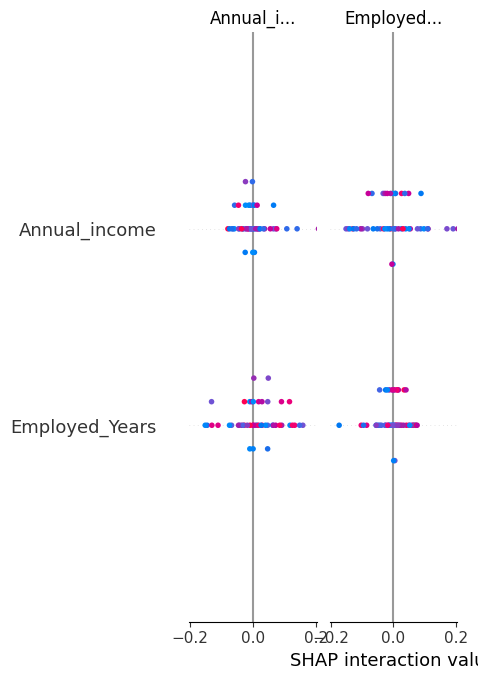

✅ SHAP plots saved: global_shap_bar_knn.png, global_shap_beeswarm_knn.png

🔹 Generating LIME explanations...

🔹 Top LIME Explanations:
Marital_status <= -0.52                  -> -0.053
-0.21 < Employed_Years <= 0.63           -> -0.050
-0.06 < Age <= 0.78                      -> +0.034
Type_Income <= -1.56                     -> -0.021
-0.72 < Annual_income <= -0.04           -> +0.009
-1.54 < Education <= 0.66                -> -0.004


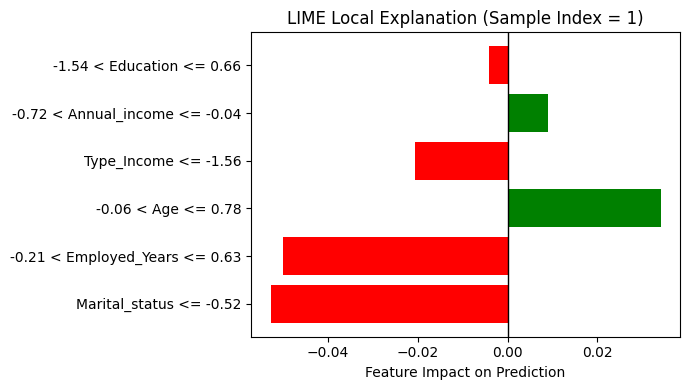


✅ LIME plots and HTML explanation generated successfully.


In [ ]:
!pip install shap lime --quiet

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lime import lime_tabular
from sklearn.metrics import accuracy_score

# ---- Model Evaluation (Your Original Code) ----
y_train_pred_knn = knn_model.predict(X_train_scaled)
train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)
print(f"Training Accuracy (KNN): {train_accuracy_knn:.2f}")

y_test_pred_knn = knn_model.predict(X_test_scaled)
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)
print(f"Testing Accuracy (KNN): {test_accuracy_knn:.2f}")

print("\n🔹 Generating SHAP explanations (may take some time)...")

# Use KernelExplainer for KNN (non-linear model)
explainer_shap = shap.KernelExplainer(
    knn_model.predict_proba,
    shap.sample(X_train_scaled, 100, random_state=42)
)

# Explain a small subset (for speed)
X_subset = X_test_scaled[:50]
shap_values = explainer_shap.shap_values(X_subset)

# --- Global SHAP Summary Plots ---
plt.title("Global Feature Importance - SHAP (Bar)")
shap.summary_plot(shap_values, X_subset, feature_names=X.columns, plot_type="bar", show=False)
plt.savefig("global_shap_bar_knn.png", bbox_inches="tight")
plt.show()

plt.title("Global Feature Importance - SHAP (Beeswarm)")
shap.summary_plot(shap_values, X_subset, feature_names=X.columns, show=False)
plt.savefig("global_shap_beeswarm_knn.png", bbox_inches="tight")
plt.show()

print("✅ SHAP plots saved: global_shap_bar_knn.png, global_shap_beeswarm_knn.png")

print("\n🔹 Generating LIME explanations...")

X_train_np = np.array(X_train_scaled)
X_test_np = np.array(X_test_scaled)

explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=X.columns.tolist(),
    class_names=['Class 0', 'Class 1'],
    discretize_continuous=True,
    mode='classification'
)

# Pick one sample to explain
sample_index = 1
x_scaled = X_test_np[sample_index]

lime_exp = explainer_lime.explain_instance(
    data_row=x_scaled,
    predict_fn=knn_model.predict_proba,
    num_features=min(10, X.shape[1])
)

# --- Text Output ---
print("\n🔹 Top LIME Explanations:")
for feat, weight in lime_exp.as_list():
    print(f"{feat:40s} -> {weight:+.3f}")

# --- Visual Output ---
lime_results = pd.DataFrame(lime_exp.as_list(), columns=['Feature', 'Contribution'])
lime_results['Sign'] = lime_results['Contribution'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

plt.figure(figsize=(7, 4))
plt.barh(
    lime_results['Feature'],
    lime_results['Contribution'],
    color=lime_results['Sign'].map({'Positive': 'green', 'Negative': 'red'})
)
plt.axvline(0, color='black', linewidth=1)
plt.xlabel("Feature Impact on Prediction")
plt.title("LIME Local Explanation (Sample Index = 1)")
plt.tight_layout()
plt.savefig("lime_local_knn.png", bbox_inches="tight")
plt.show()

# Save interactive HTML report
lime_exp.save_to_file("lime_explanation_knn.html")

print("\n✅ LIME plots and HTML explanation generated successfully.")

### 5.3 Confusion Matrix

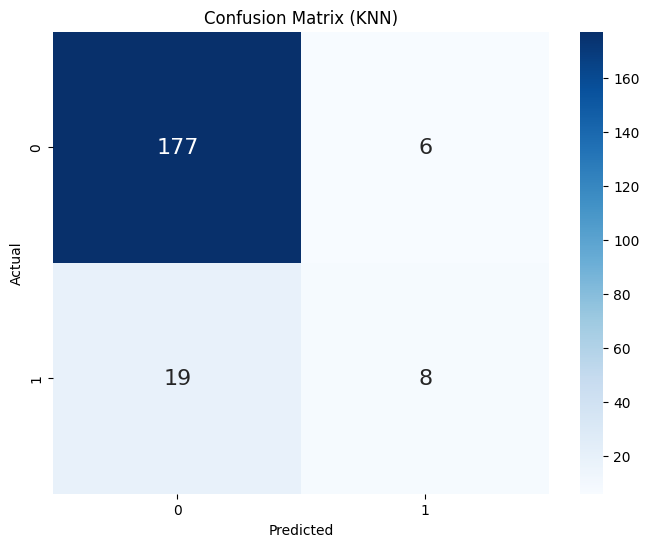

In [ ]:
# Calculating the confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_test_pred_knn)
plt.figure(figsize=(8, 6))

# Visualizing the confusion matrix with heatmap
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})

# Adding title and labels
plt.title("Confusion Matrix (KNN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Displaying the heatmap
plt.show()

### 5.4 Classification Report

In [ ]:
# Evaluating the performance of the model
class_report_knn = classification_report(y_test, y_test_pred_knn)
print("Classification Report (KNN):\n", class_report_knn)

Classification Report (KNN):
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       183
           1       0.57      0.30      0.39        27

    accuracy                           0.88       210
   macro avg       0.74      0.63      0.66       210
weighted avg       0.86      0.88      0.86       210



### 5.5 Roc Cruve (Receiver Operating Characteristic)

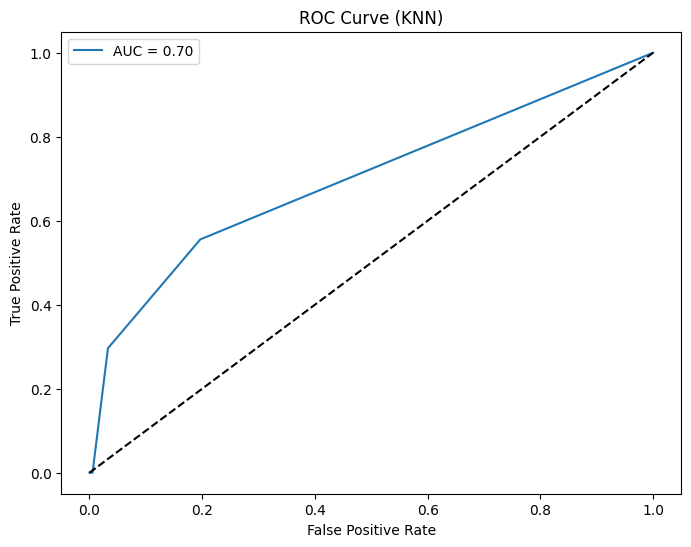

In [ ]:
# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, knn_model.predict_proba(X_test_scaled)[:, 1])

# Calculating AUC (Area Under the ROC Curve)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label=f'AUC = {roc_auc_knn:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (KNN)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### 5.6 Cross Validation

In [ ]:
# Creating a cross-validation object
random_seed = 42
kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)

# Performing cross-validation for KNN
cross_val_accuracy_knn = cross_val_score(knn_model, X_train_scaled, y_train, cv=kf, scoring='accuracy')
print(f"Cross-Validation Accuracy (KNN): {cross_val_accuracy_knn}")

# Calculating the mean cross-validation accuracy for KNN
print(f"Mean Cross-Validation Accuracy (KNN): {np.mean(cross_val_accuracy_knn):.2f}")

Cross-Validation Accuracy (KNN): [0.89880952 0.89880952 0.85628743 0.91616766 0.90419162]
Mean Cross-Validation Accuracy (KNN): 0.89


### 5.7  Hyperparameter Tuning: GridSearchCV

In [ ]:
# Setting up the parameter grid for grid search
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2]  # Power parameter for the Minkowski metric
}

# Setting up GridSearchCV for KNN
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=5, scoring='roc_auc', n_jobs=-1)

# Fitting the model with the training data
grid_search_knn.fit(X_train_scaled, y_train)

# Retrieving the best parameters from the grid search
best_params_knn = grid_search_knn.best_params_
print("Best Parameters (KNN):", best_params_knn)

Best Parameters (KNN): {'n_neighbors': 7, 'p': 2, 'weights': 'distance'}


### 5.8 Model with Best Parameters

In [ ]:
# Defining the best hyperparameters for KNN model
best_params_knn = {'n_neighbors': 7, 'p': 2, 'weights': 'distance'}

# Creating the KNN model with the best hyperparameters
best_knn_model = KNeighborsClassifier(**best_params_knn)
best_knn_model.fit(X_train_scaled, y_train)
y_pred_knn = best_knn_model.predict(X_test_scaled)

# Calculating the accuracy of the KNN model
accuracy_knn_bp = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy (KNN): {accuracy_knn_bp:.2f}")

Accuracy (KNN): 0.90


### 5.8.1 SHAP and LIME Implementation

  0%|          | 0/837 [00:00<?, ?it/s]

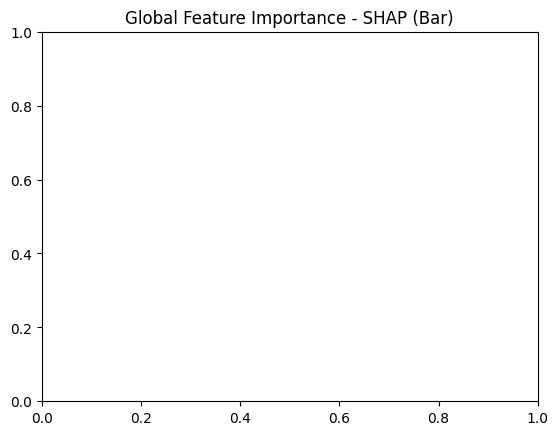

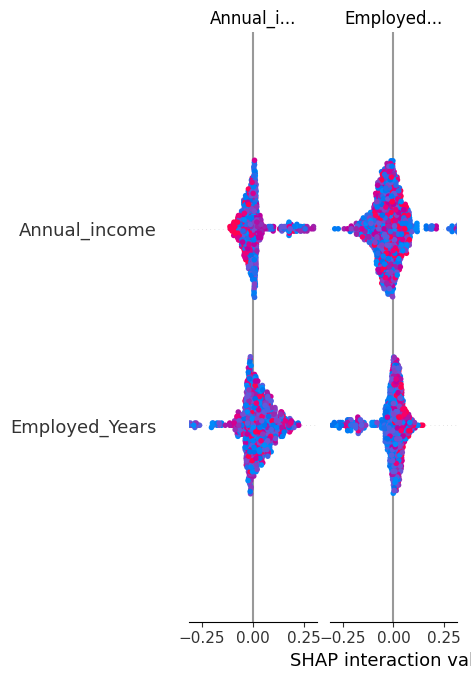

<Figure size 640x480 with 0 Axes>

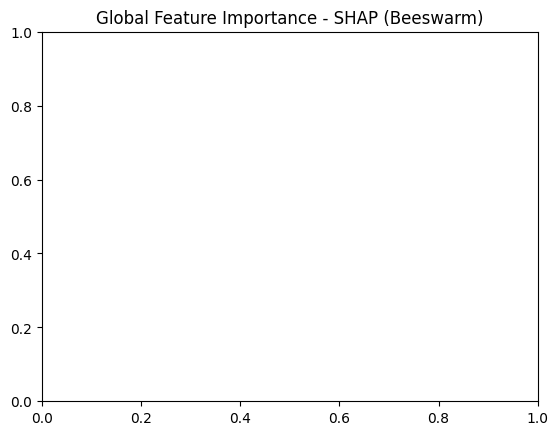

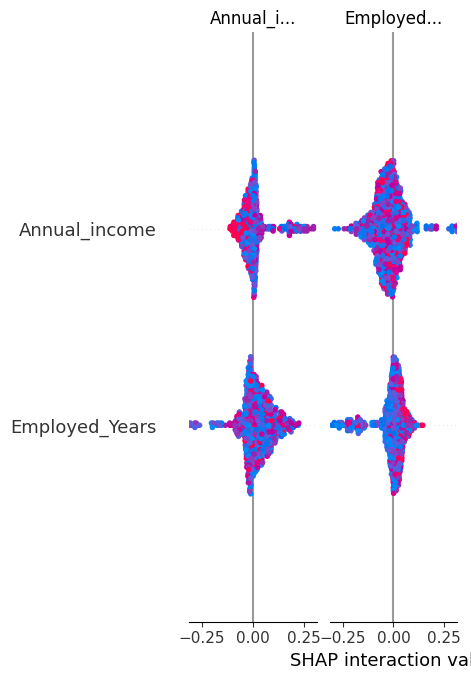

<Figure size 640x480 with 0 Axes>

✅ SHAP plots saved: global_shap_bar_knn.png, global_shap_beeswarm_knn.png

🔹 Generating LIME explanations...

🔹 Top LIME Explanations:
Marital_status <= -0.52                  -> -0.044
-0.21 < Employed_Years <= 0.63           -> -0.042
-0.06 < Age <= 0.78                      -> +0.036
Type_Income <= -1.56                     -> -0.017
-0.72 < Annual_income <= -0.04           -> +0.017
-1.54 < Education <= 0.66                -> -0.002


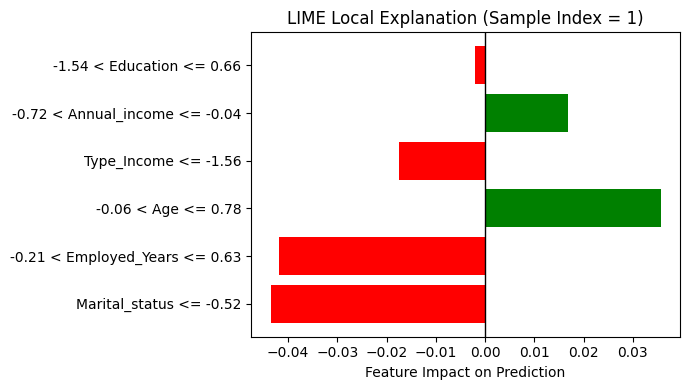


✅ LIME plots and HTML explanation generated successfully.


In [ ]:
!pip install shap lime --quiet

import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lime import lime_tabular
from sklearn.metrics import accuracy_score

# Use KernelExplainer for KNN (non-linear model)
explainer_shap = shap.KernelExplainer(
    best_knn_model.predict_proba,
    shap.sample(X_train_scaled, 100, random_state=42)
)

# Explain a small subset (for speed)
shap_values = explainer_shap.shap_values(X_train_scaled)

# --- Global SHAP Summary Plots ---
plt.title("Global Feature Importance - SHAP (Bar)")
shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns, plot_type="bar", show=True)
plt.savefig("global_shap_bar_knn.png", bbox_inches="tight")
plt.show()

plt.title("Global Feature Importance - SHAP (Beeswarm)")
shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns, show=True)
plt.savefig("global_shap_beeswarm_knn.png", bbox_inches="tight")
plt.show()

print("✅ SHAP plots saved: global_shap_bar_knn.png, global_shap_beeswarm_knn.png")

print("\n🔹 Generating LIME explanations...")

X_train_np = np.array(X_train_scaled)
X_test_np = np.array(X_test_scaled)

explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=X.columns.tolist(),
    class_names=['Class 0', 'Class 1'],
    discretize_continuous=True,
    mode='classification'
)

# Pick one sample to explain
sample_index = 1
x_scaled = X_test_np[sample_index]

lime_exp = explainer_lime.explain_instance(
    data_row=x_scaled,
    predict_fn=knn_model.predict_proba,
    num_features=min(10, X.shape[1])
)

# --- Text Output ---
print("\n🔹 Top LIME Explanations:")
for feat, weight in lime_exp.as_list():
    print(f"{feat:40s} -> {weight:+.3f}")

# --- Visual Output ---
lime_results = pd.DataFrame(lime_exp.as_list(), columns=['Feature', 'Contribution'])
lime_results['Sign'] = lime_results['Contribution'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

plt.figure(figsize=(7, 4))
plt.barh(
    lime_results['Feature'],
    lime_results['Contribution'],
    color=lime_results['Sign'].map({'Positive': 'green', 'Negative': 'red'})
)
plt.axvline(0, color='black', linewidth=1)
plt.xlabel("Feature Impact on Prediction")
plt.title("LIME Local Explanation (Sample Index = 1)")
plt.tight_layout()
plt.savefig("lime_local_knn.png", bbox_inches="tight")
plt.show()

# Save interactive HTML report
lime_exp.save_to_file("lime_explanation_knn.html")

print("\n✅ LIME plots and HTML explanation generated successfully.")

## 6. Gradient Boosting (XGBoost)

### 6.1 Model training

In [ ]:
# Creating and fitting the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss',use_label_encoder=False) # Since 'binary:logistic' was changed from 'error' to 'logloss'
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### 6.2 Model Prediction and Accuracy

In [ ]:
# Making predictions on the training set
y_train_pred_xgb = xgb_model.predict(X_train_scaled)

# Calculating training accuracy
train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
print(f"Training Accuracy (XGBoost): {train_accuracy_xgb:.2f}")

# Making predictions on the test set
y_test_pred_xgb = xgb_model.predict(X_test_scaled)

# Calculating testing accuracy
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
print(f"Testing Accuracy (XGBoost): {test_accuracy_xgb:.2f}")

Training Accuracy (XGBoost): 0.99
Testing Accuracy (XGBoost): 0.90


### 6.2.1 SHAP and LIME Implementation

  0%|          | 0/837 [00:00<?, ?it/s]


--- Debug Info ---
X_train_scaled.shape: (837, 6)
Number of SHAP classes: 837
Shape of first SHAP class: (6, 2)
Feature names length: 6


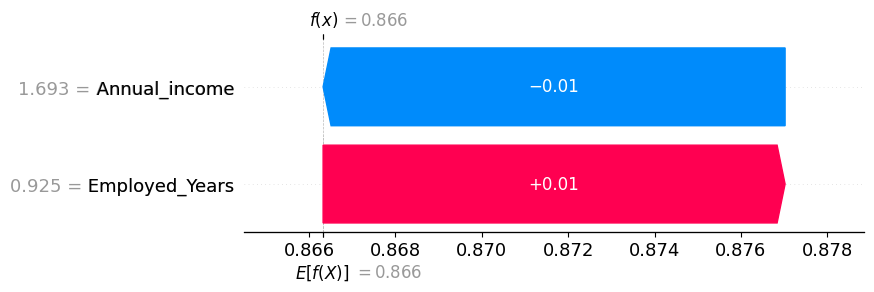

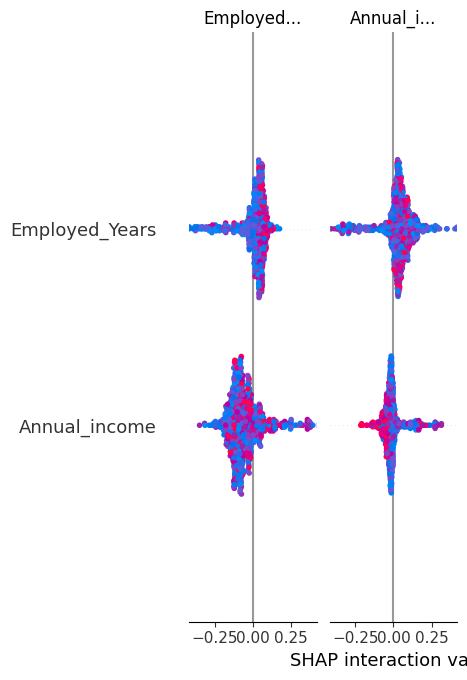

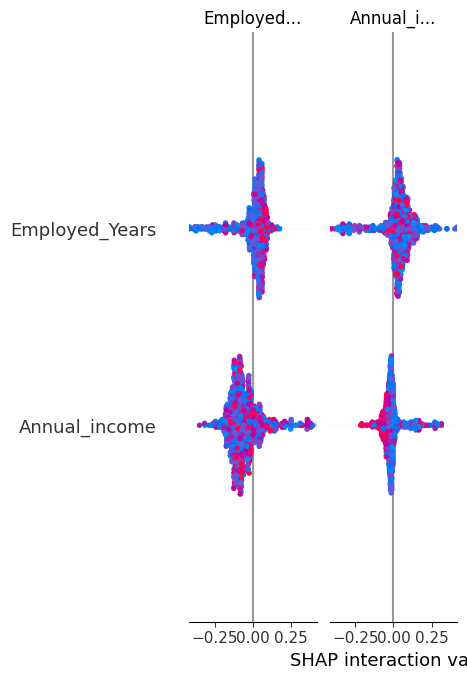

In [ ]:
# Import necessary libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

feature_names = X.columns.tolist()

# ------------------------- SHAP Explainability -------------------------
# Use KernelExplainer (model-agnostic) to avoid TreeExplainer compatibility issues
background_data = shap.sample(X_train_scaled, 100)  # Sample 100 instances for background
explainer_shap = shap.KernelExplainer(xgb_model.predict_proba, background_data)

# Calculate SHAP values (for training data)
shap_values = explainer_shap.shap_values(X_train_scaled)

# Debugging info
print("\n--- Debug Info ---")
print("X_train_scaled.shape:", X_train_scaled.shape)
print("Number of SHAP classes:", len(shap_values))
print("Shape of first SHAP class:", shap_values[0].shape)
print("Feature names length:", len(feature_names))

# Visualize explanation for a single prediction
instance_index = 0  # Change to view other instances
class_index = 0     # 0 for binary classification
explanation = shap.Explanation(
    values=shap_values[class_index][instance_index],
    base_values=explainer_shap.expected_value[class_index],
    data=X_train_scaled[instance_index],
    feature_names=feature_names
)

# Waterfall plot (local explanation)
shap.plots.waterfall(explanation)

# Global feature importance (summary plots)
shap.summary_plot(shap_values, X_train_scaled, feature_names=feature_names)
shap.summary_plot(shap_values, X_train_scaled, plot_type="bar", feature_names=feature_names)

# ------------------------- LIME Explainability -------------------------
# Define class names
class_names = ['Class 0', 'Class 1']

# ✅ Sanity check to ensure names and features align
assert len(feature_names) == X_train_scaled.shape[1], \
    f"Feature name count ({len(feature_names)}) must match number of features ({X_train_scaled.shape[1]})"

# Create LIME explainer
explainer_lime = LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Explain a single instance (e.g., first test sample)
i = 0
exp = explainer_lime.explain_instance(
    data_row=X_test_scaled[i],
    predict_fn=xgb_model.predict_proba,
    num_features=6  # Show top 6 features
)

# Display the LIME explanation
exp.show_in_notebook()  # Use exp.as_pyplot_figure() if not in Jupyter


### 6.3 Confusion Matrix

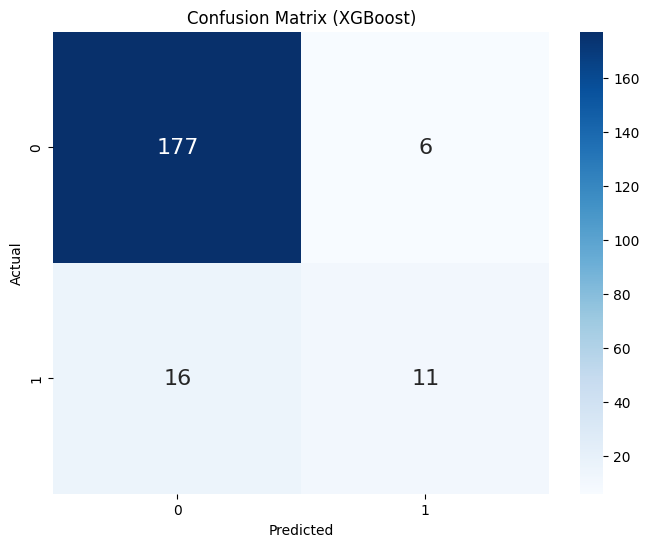

In [ ]:
# Calculating the confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_test_pred_xgb)
plt.figure(figsize=(8, 6))

# Visualizing the confusion matrix with heatmap
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})

# Adding title and labels
plt.title("Confusion Matrix (XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Displaying the heatmap
plt.show()

### 6.4 Classification Report

In [ ]:
# Evaluating the performance of the model
class_report_xgb = classification_report(y_test, y_test_pred_xgb)
print("Classification Report (XGBoost):\n", class_report_xgb)

Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.92      0.97      0.94       183
           1       0.65      0.41      0.50        27

    accuracy                           0.90       210
   macro avg       0.78      0.69      0.72       210
weighted avg       0.88      0.90      0.88       210



### 6.5 Roc Cruve (Receiver Operating Characteristic)

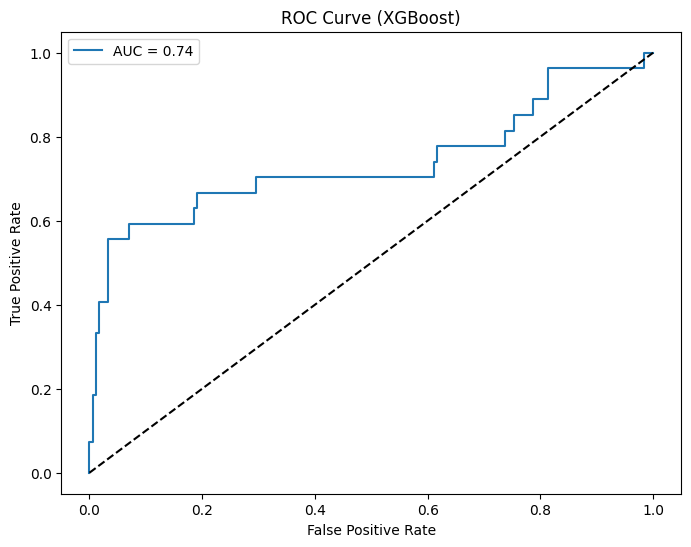

In [ ]:
# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_model.predict_proba(X_test_scaled)[:, 1])

# Calculating AUC (Area Under the ROC Curve)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'AUC = {roc_auc_xgb:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (XGBoost)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### 6.6 Cross Validation

In [ ]:
# Creating a cross-validation object
random_seed = 42
kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)

# Performing cross-validation for XGBoost model
cross_val_accuracy_xgboost = cross_val_score(xgb_model, X_train_scaled, y_train, cv=kf, scoring='accuracy')
print(f"Cross-Validation Accuracy (XGBoost): {cross_val_accuracy_xgboost}")

# Calculating the mean cross-validation accuracy for XGBoost model
print(f"Mean Cross-Validation Accuracy (XGBoost): {np.mean(cross_val_accuracy_xgboost):.2f}")

Cross-Validation Accuracy (XGBoost): [0.91071429 0.93452381 0.88622754 0.94011976 0.93413174]
Mean Cross-Validation Accuracy (XGBoost): 0.92


### 6.7  Hyperparameter Tuning: GridSearchCV

In [ ]:
# Setting up the parameter grid for grid search
param_grid_xgboost = {
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage used to prevent overfitting
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'max_depth': [3, 5, 7],  # Maximum depth of a tree
    'subsample': [0.8, 1.0],  # Fraction of samples used for fitting the individual trees
}

# Setting up GridSearchCV for XGBoost model
grid_search_xgboost = GridSearchCV(xgb_model, param_grid_xgboost, cv=5, scoring='roc_auc', n_jobs=-1)

# Fitting the model with the training data
grid_search_xgboost.fit(X_train_scaled, y_train)

# Retrieving the best parameters from the grid search
best_params_xgboost = grid_search_xgboost.best_params_
print("Best Parameters (XGBoost):", best_params_xgboost)

Best Parameters (XGBoost): {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


### 6.8 Model with Best Parameters

In [ ]:
# Defining the best hyperparameters for XGBoost
best_params_xgboost = {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}

# Creating the XGBoost model with the best hyperparameters
best_xgboost_model = xgb.XGBClassifier(**best_params_xgboost, random_state=42, eval_metric='logloss',use_label_encoder=False)
best_xgboost_model.fit(X_train_scaled, y_train)
y_pred_xgboost = best_xgboost_model.predict(X_test_scaled)

# Calculating the accuracy of the XGBoost
accuracy_xgboost_pb = accuracy_score(y_test, y_pred_xgboost)
print(f"Accuracy (XGBoost): {accuracy_xgboost_pb:.2f}")

Accuracy (XGBoost): 0.89


### 6.8.1 SHAP and LIME Implementation

  0%|          | 0/837 [00:00<?, ?it/s]


--- Debug Info ---
X_train_scaled.shape: (837, 6)
Number of SHAP classes: 837
Shape of first SHAP class: (6, 2)
Feature names length: 6


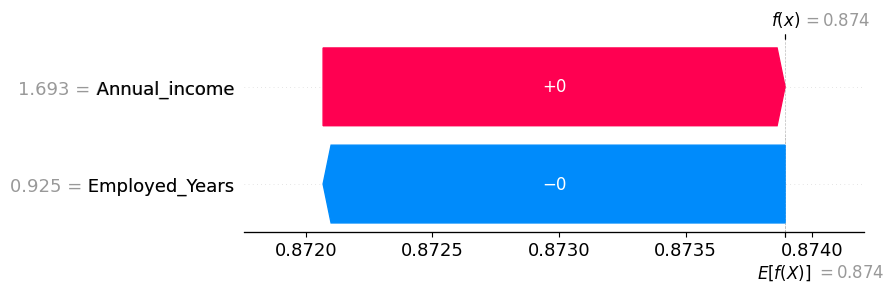

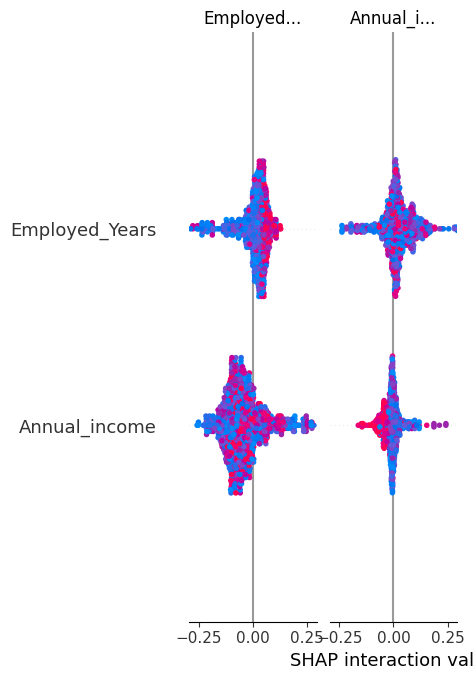

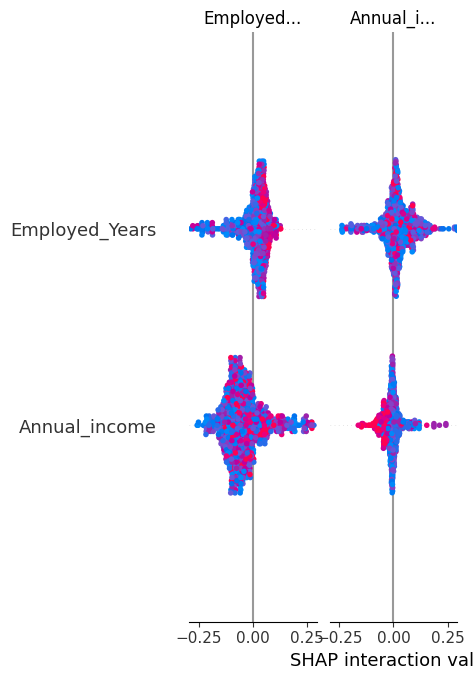

In [ ]:
# Import necessary libraries
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

feature_names = X.columns.tolist()

# ------------------------- SHAP Explainability -------------------------
# Use KernelExplainer (model-agnostic) to avoid TreeExplainer compatibility issues
background_data = shap.sample(X_train_scaled, 100)  # Sample 100 instances for background
explainer_shap = shap.KernelExplainer(best_xgboost_model.predict_proba, background_data)

# Calculate SHAP values (for training data)
shap_values = explainer_shap.shap_values(X_train_scaled)

# Debugging info
print("\n--- Debug Info ---")
print("X_train_scaled.shape:", X_train_scaled.shape)
print("Number of SHAP classes:", len(shap_values))
print("Shape of first SHAP class:", shap_values[0].shape)
print("Feature names length:", len(feature_names))

# Visualize explanation for a single prediction
instance_index = 0  # Change to view other instances
class_index = 0     # 0 for binary classification
explanation = shap.Explanation(
    values=shap_values[class_index][instance_index],
    base_values=explainer_shap.expected_value[class_index],
    data=X_train_scaled[instance_index],
    feature_names=feature_names
)

# Waterfall plot (local explanation)
shap.plots.waterfall(explanation)

# Global feature importance (summary plots)
shap.summary_plot(shap_values, X_train_scaled, feature_names=feature_names)
shap.summary_plot(shap_values, X_train_scaled, plot_type="bar", feature_names=feature_names)

# ------------------------- LIME Explainability -------------------------
# Define class names
class_names = ['Class 0', 'Class 1']

# Check to ensure names and features align
assert len(feature_names) == X_train_scaled.shape[1], \
    f"Feature name count ({len(feature_names)}) must match number of features ({X_train_scaled.shape[1]})"

# Create LIME explainer
explainer_lime = LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Explain a single instance (e.g., first test sample)
i = 0
exp = explainer_lime.explain_instance(
    data_row=X_test_scaled[i],
    predict_fn=best_xgboost_model.predict_proba,
    num_features=6  # Show top 6 features
)

# Display the LIME explanation
exp.show_in_notebook()  # Use exp.as_pyplot_figure() if not in Jupyter


# 3. Model Selection

In [ ]:
variables = {
    'Logistic Regression': [test_accuracy, accuracy_lr, cross_val_accuracy_lr, roc_auc_lr],
    'Decision Tree': [accuracy_dt, accuracy_dt_bp, cross_val_accuracy_dt, roc_auc_dt],
    'Random Forest': [test_accuracy_rf, accuracy_rf_bp, cross_val_accuracy_rf, roc_auc_rf],
    'Support Vector Machine': [test_accuracy_svm, accuracy_svm_bp, cross_val_accuracy_svm, roc_auc_svm],
    'K-Nearest Neighbour': [test_accuracy_knn, accuracy_knn_bp, cross_val_accuracy_knn, roc_auc_knn],
    'Gradient Boosting': [test_accuracy_xgb, accuracy_xgboost_pb, cross_val_accuracy_xgboost, roc_auc_xgb]
}

# Calculate mean for the "Mean Cross-Validation Accuracy" column
for model, vars_list in variables.items():
    vars_list[2] = sum(vars_list[2]) / len(vars_list[2])

# Convert the dictionary to a DataFrame
model_selection_df = pd.DataFrame.from_dict(variables, orient='index', columns=['Testing Accuracy before Hypertuning', 'Testing Accuracy after Hypertuning', 'Mean Cross-Validation Accuracy', 'AUC'])

# Format all values to two decimal places
model_selection_df = model_selection_df.applymap(lambda x: f'{x:.2f}' if isinstance(x, (float, int)) else x)

# Display the results
model_selection_df


Testing Accuracy before Hypertuning  \
Logistic Regression                                   0.87   
Decision Tree                                         0.84   
Random Forest                                         0.91   
Support Vector Machine                                0.87   
K-Nearest Neighbour                                   0.88   
Gradient Boosting                                     0.90   

                       Testing Accuracy after Hypertuning  \
Logistic Regression                                  0.87   
Decision Tree                                        0.85   
Random Forest                                        0.90   
Support Vector Machine                               0.87   
K-Nearest Neighbour                                  0.90   
Gradient Boosting                                    0.89   

                       Mean Cross-Validation Accuracy   AUC  
Logistic Regression                              0.91  0.61  
Decision Tree                                    0.88  0.71  
Random Forest                                    0.93  0.74  
Support Vector Machine                           0.91  0.71  
K-Nearest Neighbour                              0.89  0.70  
Gradient Boosting                                0.92  0.74

#### Testing Accuracy:

- **Random Forest:** It has the highest testing accuracy after hypertuning (0.90). This suggests that, on the test set, it performs well in correctly predicting credit card approval.

#### Mean Cross-Validation Accuracy:

- **Random Forest:** It again shows the highest mean cross-validation accuracy (0.93). This indicates consistent and robust performance across different subsets of the training data.

#### AUC (Area Under the ROC Curve):

- **Random Forest and Gradient Boosting:** Both have the highest AUC values (0.74), indicating good discrimination ability between positive and negative classes.

### Model Selected - Random Forest

In [ ]:
import joblib
import numpy as np
import pandas as pd

# ---------------- Step 1: Combine all model metrics ----------------
variables = {
    'Logistic Regression': [test_accuracy, accuracy_lr, cross_val_accuracy_lr, roc_auc_lr, log],
    'Decision Tree': [accuracy_dt, accuracy_dt_bp, cross_val_accuracy_dt, roc_auc_dt, model_dt],
    'Random Forest': [test_accuracy_rf, accuracy_rf_bp, cross_val_accuracy_rf, roc_auc_rf, model_rf],
    'Support Vector Machine': [test_accuracy_svm, accuracy_svm_bp, cross_val_accuracy_svm, roc_auc_svm, model_svm],
    'K-Nearest Neighbour': [test_accuracy_knn, accuracy_knn_bp, cross_val_accuracy_knn, roc_auc_knn, model_knn],
    'Gradient Boosting (XGBoost)': [test_accuracy_xgb, accuracy_xgboost_pb, cross_val_accuracy_xgboost, roc_auc_xgb, best_xgb_model]
}

# ---------------- Step 2: Compute Mean Cross-Validation Accuracy ----------------
for model_name, values in variables.items():
    if isinstance(values[2], (list, np.ndarray)):
        values[2] = np.mean(values[2])  # Average CV accuracy

# ---------------- Step 3: Create DataFrame ----------------
model_selection_df = pd.DataFrame.from_dict(
    variables,
    orient='index',
    columns=[
        'Test Accuracy (Before)',
        'Test Accuracy (After)',
        'Mean CV Accuracy',
        'ROC-AUC',
        'Model Object'
    ]
)

# ---------------- Step 4: Compute overall performance score ----------------
model_selection_df['Overall Score'] = (
    0.5 * model_selection_df['Mean CV Accuracy'] +
    0.5 * model_selection_df['ROC-AUC']
).round(3)

# ---------------- Step 5: Select the best model ----------------
best_model_name = model_selection_df['Overall Score'].idxmax()
best_model = model_selection_df.loc[best_model_name, 'Model Object']

print(f"🏆 Best Model Selected: {best_model_name}")
print(model_selection_df[['Mean CV Accuracy', 'ROC-AUC', 'Overall Score']])

# ---------------- Step 6: Save the best model ----------------
joblib.dump(best_model, f"best_model_{best_model_name.replace(' ', '_').lower()}.pkl")
print(f" Model saved as best_model_{best_model_name.replace(' ', '_').lower()}.pkl")

NameError: name 'log' is not defined

# 4. Feature Importance on Random Forest Model
Using Entropy

In [ ]:
# Extracting feature importances
feature_importances_entropy = best_rf_model.feature_importances_

# Getting the names of features
feature_names_entropy = X_train.columns

# Sorting feature importances in descending order
indices_entropy = feature_importances_entropy.argsort()[::-1]

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances_entropy[indices_entropy], align="center")
plt.xticks(range(X_train.shape[1]), feature_names_entropy[indices_entropy], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Feature Importance (Entropy)")
plt.title("Random Forest - Feature Importances (Entropy)")
plt.show()